<a href="https://colab.research.google.com/github/inf032/introducaoML/blob/master/Farm03.Metricas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [128]:
!pip install catboost
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Importação de Bibliotecas**


In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics  import mean_squared_error
from sklearn.dummy import DummyRegressor

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer
from sklearn.impute._base import _BaseImputer




**Classe para imputação e coluna de missing**

In [130]:
class ImputerWithMissingMark (BaseEstimator, TransformerMixin):

    def transformColunas_IMPUTED(self, X) -> pd.DataFrame :
      copia = X.copy()
      for col in self.col_name_with_nan :
          copia[f'{col}{self.postfix}'] = copia[col].isna().astype(int)
      return copia      

    def col_with_nan(self, X) -> list:
      list_col_with_nan = []
      copia = X.copy()
      for col in copia.columns :
        if(copia[col].isna().sum() > 0) :
          list_col_with_nan.append(col)
      return list_col_with_nan

    def col_num_with_nan(self, X) -> list:
      cols = X.shape[1]
      list_col_with_nan = []
      for col in range(cols):    
          if(np.count_nonzero(np.isnan(X[:,col])) > 0) :  
              list_col_with_nan.append(col)
      return list_col_with_nan        

    def __init__(self, imputer=KNNImputer(), postfix = '_IMPUTED'):
      self.imputer = imputer
      self.col_name = None
      self.fitted = False
      self.col_name_with_nan = None
      self.col_number_with_nan = None
      self.postfix = postfix

    def fit_DF(self, X):
      self.col_name = X.columns.values
      self.col_name_with_nan = self.col_with_nan(X)

    def fit_NP(self, X):
      self.col_number_with_nan = self.col_num_with_nan(X)

    def transform_DF(self, X):
      copia = self.transformColunas_IMPUTED(X)
      transformed = pd.DataFrame(self.imputer.transform(copia[self.col_name]))
      transformed.columns = X.columns
      transformed.index = X.index
      for col in self.col_name_with_nan :
        transformed[f'{col}{self.postfix}'] = copia[f'{col}{self.postfix}']
      return transformed

    def transform_NP(self, X):
      transformed = np.copy(X)
      vazio = np.zeros(shape=(X.shape[0],0))
      for col in self.col_number_with_nan:
        a_nan = [1 if np.isnan(x) else 0 for x in transformed[:,col]]
        vazio = np.append(vazio, np.c_[a_nan], axis = 1)
      transformed = self.imputer.transform(transformed)  
      for col in range(vazio.shape[1]) :
        transformed = np.append(transformed, np.c_[vazio[:, col]], axis = 1)
      return transformed      

    def fit(self, X, y=None):
      if(self.fitted == False) :
        self.fitted = True
        if(type(X) == pd.DataFrame) :
          self.fit_DF(X)
        else :
          self.fit_NP(X)  
        self.imputer.fit(X)
      return self

    def transform(self, X, y=None):
      if(self.fitted == True) :
        if(self.col_name is not None) :
          transformed = self.transform_DF(X)    
        else :
          transformed = self.transform_NP(X)    
        return transformed
      else :
        return X

    def get_params(self, deep=True):
      # retorna um dicionário com os atributos e seus respectivos valores
      return {"imputer": self.imputer, 
              "postfix": self.postfix}
      
    def set_params(self, **parameters):
      # iterando pelos elementos passados e definindo-os na classe
      for parameter, value in parameters.items():
        setattr(self, parameter, value)
      return self 

**Leitura dos Dados e Holdout**


In [131]:
SEED = 1234
np.random.seed(SEED)
warnings.filterwarnings(action='once')

df = pd.read_csv('https://raw.githubusercontent.com/inf032/introducaoML/master/data/farmaco.csv')
df.columns = ['IDADE', 'SEXO', 'PA', 'COLESTEROL', 'NA_K', 'FARMACO']
preditoras = ['IDADE', 'SEXO', 'PA', 'COLESTEROL', 'NA_K']
alvo = 'FARMACO'

X = df[preditoras]
y = df[alvo]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=SEED)

print(f'Holdout: {X_train.shape[0]} individuos em treino. {X_test.shape[0]} individuos em teste.')

Holdout: 157 individuos em treino. 68 individuos em teste.


**Criação do Pipeline**

In [132]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

ordinal_transformer = Pipeline(steps=[('ordinal_encoder', OrdinalEncoder(categories=[['LOW', 'NORMAL', 'HIGH'], 
                                                                                     ['LOW', 'NORMAL', 'HIGH']], 
                                                                          handle_unknown='use_encoded_value',
                                                                          unknown_value=np.nan))
                                     ])
onehot_transformer = Pipeline(steps=[('one_hot_encoder',  OneHotEncoder(drop='if_binary', sparse=False))])


col_transformer = ColumnTransformer(transformers=[('pa_colesterol', ordinal_transformer, ['PA', 'COLESTEROL']),
                                                  ('sex', onehot_transformer, ['SEXO'])],
                                    remainder='passthrough')

**Criação de Tipos diferentes de classificadores, que serão usados na comparação**

In [133]:
from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

nomes = ['Dummy', 'CatBoost', 'XGB', 'LightGBM', 'Random Forest', 'Rede Neural', 
         'Neural Net']

classificadores = [DummyClassifier(strategy='stratified'),
                   CatBoostClassifier(verbose=0), XGBClassifier(verbosity=0),
                   LGBMClassifier(),
                   RandomForestClassifier(),
                   MLPClassifier(max_iter=650)]

**Função para Cálculo de Métricas**




In [134]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix

def calcular_metricas(model, X_test, y_true) :
  y_pred = model.predict(X_test)
  acuracia = accuracy_score(y_true, y_pred)
  precisao = precision_score(y_true, y_pred, average='macro')
  sensibilidade = recall_score(y_true, y_pred, average='macro')
  f1 = f1_score(y_true, y_pred, average='macro')
  return acuracia, precisao, sensibilidade, f1

def print_confusion_matrix(model, X_test, y_true) :
  y_pred = model.predict(X_test)
  cm = confusion_matrix(y_test, y_true)
  print(cm)


**Função para Matriz de Confusão**

In [144]:
def print_confusion_matrix(model, X_test, y_true) :
  y_pred = model.predict(X_test)
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, xticklabels=['MEDA - Predição', 'MEDB - Predição'], 
              yticklabels=['MEDA - Real', 'MEDB - Real'])
  

def graph_confusion_matrix(model, X_test, y_true) :
  y_pred = model.predict(X_test)
  cm = confusion_matrix(y_true, y_pred)
  print(cm)


**Avaliação do Desempenho dos Classificadores**


In [136]:
resultados = []

for nome, model in zip(nomes, classificadores) :
    model = Pipeline(steps=[('step_one', col_transformer), ('ss',  StandardScaler()), 
                           ('imputer', ImputerWithMissingMark()), ('classificador', model)]).fit(X_train, y_train)

    y_pred = model.predict(X_test)
    acuracia, precisao, sensibilidade, f1 = calcular_metricas(model, X_test, y_test)                       
    resultados.append([nome, acuracia, precisao, sensibilidade, f1])
    
dfResultados = pd.DataFrame(resultados, columns = ['CLASSIFICADOR', 'ACURACIA', 'PRECISAO', 'SENSIBILIDADE', 'F1'])

dfResultados


,CLASSIFICADOR,ACURACIA,PRECISAO,SENSIBILIDADE,F1
0,Dummy,0.455882,0.453125,0.452921,0.452925
1,CatBoost,0.985294,0.984375,0.986486,0.985214
2,XGB,0.985294,0.984375,0.986486,0.985214
3,LightGBM,0.970588,0.970357,0.970357,0.970357
4,Random Forest,0.970588,0.970357,0.970357,0.970357
5,Rede Neural,0.926471,0.925347,0.927201,0.926071


**Matriz de Confusão do Preditor**

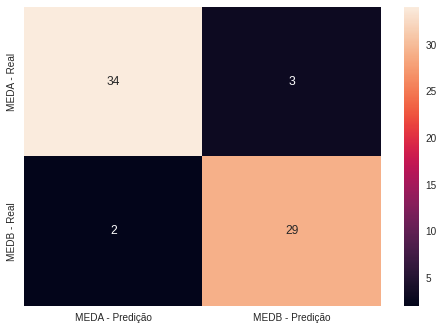

In [145]:
model = Pipeline(steps=[('step_one', col_transformer), ('ss',  StandardScaler()), 
                        ('imputer', ImputerWithMissingMark()), 
                        ('classificador', MLPClassifier(max_iter=700))]).fit(X_train, y_train)

print_confusion_matrix(model, X_test, y_test)

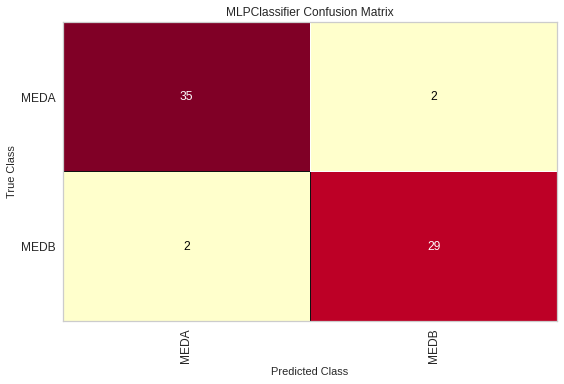

In [146]:
from yellowbrick.classifier import ConfusionMatrix

model = Pipeline(steps=[('step_one', col_transformer), ('ss',  StandardScaler()), 
                        ('imputer', ImputerWithMissingMark()), 
                        ('classificador', MLPClassifier(max_iter=700))]).fit(X_train, y_train)

cm = ConfusionMatrix(model, classes=['MEDA', 'MEDB'])
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

**Gráfico com a comparação dos Valores de Acurácia**




In [138]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go

def print_metrica(dfResultados, metrica) :
  fig = go.Figure()
  fig = px.scatter(dfResultados, x='CLASSIFICADOR', y=metrica)
  fig.update_layout(
      title="Acurácia por Modelo",
      xaxis_title="Classificador",
      yaxis_title= metrica,
      font=dict(
          family="Verdana",
          size=16,
          color="RebeccaPurple"
      )
  )
  fig.show()

print_metrica(dfResultados, 'F1')  

**Avaliação do Score dos Classificadores com Validação Cruzada (IC: 95%)**

In [139]:
from sklearn.model_selection import cross_validate


resultados_cv = []

for nome, model in zip(nomes, classificadores) :
    modelo = Pipeline(steps=[('step_one', col_transformer), ('ss',  StandardScaler()), 
                           ('imputer', ImputerWithMissingMark()), ('classificador', model)])
    resultado_cv = cross_validate(modelo, X_train, y_train, cv=5)
    resultados_cv.append([nome, np.round(resultado_cv['test_score'].mean()*100,2), np.round(resultado_cv['test_score'].std()*100,2)])
    
dfResultados_cv = pd.DataFrame(resultados_cv, columns = ['CLASSIFICADOR', 'ACURACIA_MEDIA', 'ACURACIA_STD'])

dfResultados_cv

,CLASSIFICADOR,ACURACIA_MEDIA,ACURACIA_STD
0,Dummy,46.37,11.85
1,CatBoost,96.81,2.04
2,XGB,96.17,2.43
3,LightGBM,95.56,2.52
4,Random Forest,96.81,2.04
5,Rede Neural,91.73,3.25


**Gráfico com a comparação dos Valores de Acurácia (IC: 95%)**

In [140]:
fig = px.scatter(dfResultados_cv, x='CLASSIFICADOR', y='ACURACIA_MEDIA', 
                 error_y='ACURACIA_STD')
fig.update_layout(
    title="Acurácia por Modelo",
    xaxis_title="Classificador",
    yaxis_title="Acurácia",
    font=dict(
        family="Verdana",
        size=16,
        color="RebeccaPurple"
    )
)
fig.show()